In [12]:
### Import libraries

import igraph as ig
import numpy as np
import os
from collections import Counter, OrderedDict
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from auxiliar_bb import apply_backboning
from auxiliar_projections_large import apply_projection
from auxiliar_optimization import *
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

In [13]:
### Select dataset
DATASET = "amz" # ["amz", "um", "am"]
PROJ_NAMES = ["simple", "vector", "jaccard", "neighs", "hyper", "resall"]

nombre_proyecciones = {
    "simple": "Weighted", "jaccard": "Jaccard", "hyper": "Hyperbolic",
    "vector": "Vectorized", "resall": "Resource\nAllocation", "neighs": "Neighborhood"
}
nombre_backbonings = { "NC": "Noise Corrected", "DF": "Disparity Filter"}
COLORS_PR = ["#ef476fff", "#f78c6bff", "#ffd166ff", "#06d6a0ff", "#118ab2ff", "#718355"]
COLORS_BB = [ "#8ab17d", "#e9c46a"]
COLORS_SV = ["#718355", "#87986a", "#97a97c", "#b5c99a"]

if DATASET == "um":
    FILENAME = "../12-third_year/00-Data/08-imdb/user-movie.graphml"
elif DATASET == "am":
    FILENAME = "/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/00-Data/05-actor-movie/actor-movie.graphml"
elif DATASET == "amz":
    FILENAME = "binet-AMZ-Rw.graphml"


### Auxiliar functions and variables

In [15]:
# Auxiliar functions
def plot_pie_subplots(proyecciones, backbonings, significancias, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    categories = [
        (proyecciones, "Projections types"),
        (backbonings, "Backboning methods"),
        (OrderedDict(sorted(significancias.items(), key=lambda x: float(x[0]))), "Significance value")
    ]
    color_counter = 0
    for ax, (data, subtitle) in zip(axes, categories):
        labels = list(data.keys())
        sizes = list(data.values())

        if color_counter == 0:
            ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=COLORS_PR)
        elif color_counter == 1:
            ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=COLORS_BB)
        else:
            ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=COLORS_SV)
        color_counter += 1
        ax.set_title(subtitle)
        ax.axis('equal')

    fig.suptitle(f"Distribution of network instance characteristics - {title}", fontsize=14)
    plt.tight_layout()
    plt.savefig(title + "-pastel.png")
    plt.show()

# Función principal
def analizar_frente(front, nombre="Frente"):
    proyecciones = Counter()
    backbonings = Counter()
    significancias = Counter()

    for sol in front:
        if isinstance(sol, dict):
            fname = sol["filename"]
        else:
            fname = sol

        parts = fname.split("_")
        if len(parts) == 3:
            proj, back, alpha = parts

            proj_label = nombre_proyecciones.get(proj, proj)
            back_label = nombre_backbonings.get(back, back)

            proyecciones[proj_label] += 1
            backbonings[back_label] += 1

            if alpha.startswith('a'):
                alpha_val = alpha[1:]
                if len(alpha_val) == 1:
                    alpha_val = f"0.{alpha_val}0"
                elif len(alpha_val) == 2:
                    alpha_val = f"0.{alpha_val}"
                else:
                    alpha_val = f"0.{alpha_val[:2]}"
                significancias[alpha_val] += 1

    print(f"\nResumen para {nombre}")
    print("Proyecciones:", dict(proyecciones))
    print("Backbonings:", dict(backbonings))
    print("Significancias:", dict(significancias))

    # Mostrar los subplots
    plot_pie_subplots(proyecciones, backbonings, significancias, nombre)

### Mapa de figuras, colores, y líneas.

projection_styles = {
    "simple": "tab:blue",
    "jaccard": "tab:orange",
    "neighs": "tab:green",
    "hyper": "tab:red",
    "resall": "tab:purple",
    "vector": "tab:brown"
}


backboning_styles = {
    "DF": "-",    # línea continua
    "NC": "--"    # línea punteada
}

alpha_styles = {
    "a05": "o",   # círculo
    "a1": "s",   # cuadrado
    "a15": "*",   # rombo
    "a2": "^"    # triángulo
}

projection_labels = {
    "simple": "Simple",
    "jaccard": "Jaccard",
    "vector": "Vectorized",
    "neighs": "Neighborhood",
    "hyper": "Hyperbolic",
    "resall": "Resource Allocation"
}

backboning_labels = {
    "DF": "Disparity Filter",
    "NC": "Noise Corrected"
}

alpha_labels = {
    "a05": "0.05",
    "a1": "0.10",
    "a15": "0.15",
    "a2": "0.20"
}

backboning_styles2 = { 'DF': "full", 'NC': "none"}

### Load Dataset

In [16]:
g = ig.read(FILENAME)
print(g.summary())
print()

top_nodes = g.vs.select(type=0)
bot_nodes = g.vs.select(type=1)

print("|U|=",len(top_nodes), " \t|R|=",len(bot_nodes), " \t|U|+|R|=",
      len(top_nodes)+len(bot_nodes), "=", g.vcount())
print()

if(g.is_bipartite()): # Check if the the graph is bipartite
    print("The graph IS bipartite")
else:
    print("The graph IS NOT bipartite")
    exit()


IGRAPH U-WT 17079 32769 -- 
+ attr: freq (v), id (v), type (v), weight (e)

|U|= 9561  	|R|= 7518  	|U|+|R|= 17079 = 17079

The graph IS bipartite


In [17]:
NODETYPE = 0   # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
#bip_metrics = compute_bip_metrics(gb, NODETYPE)
bip_metrics = {'x1': 9561,
 'x2': 7518,
 'x3': 32769,
 'x8': 0.245,
 'x9': 5.628737133833499,
 'x11': 3.8553228787812426, 'x15': gb.density(), 'x16': statistics.mean(gb.degree(gb.vs.select(type=0)))}

bip_metrics

{'x1': 9561,
 'x2': 7518,
 'x3': 32769,
 'x8': 0.245,
 'x9': 5.628737133833499,
 'x11': 3.8553228787812426,
 'x15': 0.00022469516962160804,
 'x16': 3.427361154690932}

In [18]:
# Directorio de proyecciones
proj_dir = DATASET + ("/top" if NODETYPE == 0 else "/bot")

# Directorio para guardar métricas cacheadas
metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
os.makedirs(metrics_cache_dir, exist_ok=True)

# Lista de archivos de métricas
metrics_files = [f for f in os.listdir(metrics_cache_dir) if f.endswith("_metrics.pkl")]

solutions = []
to_df = []
names_df = []

for fname in metrics_files:
    cache_path = os.path.join(metrics_cache_dir, fname)

    # Cargar las métricas ya calculadas
    with open(cache_path, 'rb') as f:
        proj_metrics = pickle.load(f)

    # Nombre base del archivo (quita el sufijo "_metrics.pkl")
    base_name = fname.replace("_metrics.pkl", "")

    sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE)
    to_df.append(sol["f"])
    names_df.append(base_name)
    sol["filename"] = base_name

    if is_feasible(sol):
        solutions.append(sol)

# Crear dataset final
a = pd.DataFrame(to_df, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
#a = pd.DataFrame(to_df, columns=['f1', 'f2'])
b = pd.DataFrame(names_df, columns=["name"])
final_DF = pd.concat([a, b], axis=1)

print("All solutions:", len(metrics_files))
print("Feasible solutions:", len(solutions))


All solutions: 48
Feasible solutions: 40


In [19]:
### Compute the pareto fronts

all_fronts = pareto_rank_all(solutions)
counter_sols = []

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")
    for sol_i in front:
        clean_name = sol_i["filename"][8:]
        print(clean_name)
        counter_sols.append(clean_name)

#analizar_frente(counter_sols, DATASET.upper()+" Top")


Frente 1 (34 soluciones):
hyper_DF_a1
resall_NC_a15
neighs_DF_a15
simple_NC_a05
hyper_NC_a1
resall_NC_a05
hyper_NC_a15
simple_NC_a15
jaccard_NC_a15
vector_NC_a15
vector_NC_a2
hyper_DF_a15
neighs_NC_a15
neighs_NC_a05
hyper_NC_a05
resall_DF_a15
hyper_DF_a2
vector_DF_a15
resall_DF_a1
simple_NC_a1
vector_NC_a05
hyper_DF_a05
jaccard_DF_a1
resall_DF_a2
neighs_NC_a2
hyper_NC_a2
neighs_DF_a2
vector_DF_a2
resall_NC_a1
vector_NC_a1
neighs_DF_a1
resall_DF_a05
jaccard_DF_a15
jaccard_DF_a2

Frente 2 (6 soluciones):
jaccard_NC_a05
jaccard_NC_a2
simple_NC_a2
neighs_NC_a1
resall_NC_a2
jaccard_NC_a1


Matriz de correlación:
          f1        f2        f3        f4        f5        f6
f1  1.000000 -0.561641 -0.092932 -0.067987 -0.672224 -0.197655
f2 -0.561641  1.000000  0.570105  0.107438  0.872106 -0.326191
f3 -0.092932  0.570105  1.000000  0.279059  0.521410 -0.501024
f4 -0.067987  0.107438  0.279059  1.000000  0.171098 -0.114121
f5 -0.672224  0.872106  0.521410  0.171098  1.000000 -0.203137
f6 -0.197655 -0.326191 -0.501024 -0.114121 -0.203137  1.000000


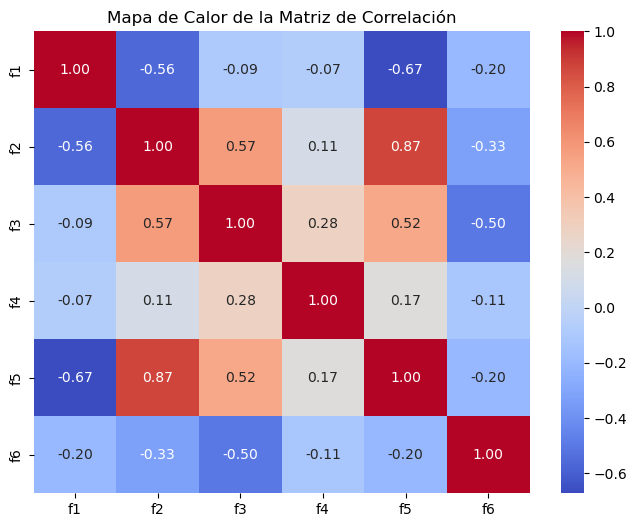

In [20]:
# Calculamos la matriz de correlación
correlation_matrix = final_DF[final_DF.columns[:-1]].corr()

print("Matriz de correlación:")
print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

# Usamos la matriz de correlación que calculamos antes
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de la Matriz de Correlación')
plt.show()

In [21]:
NODETYPE = 1    # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
#bip_metrics = compute_bip_metrics(gb, NODETYPE)
bip_metrics = {'x1': 9561,
 'x2': 7518,
 'x3': 32769,
 'x8': 0.245,
 'x9': 5.628737133833499,
 'x11': 3.8553228787812426, 'x15': gb.density(), 'x16': statistics.mean(gb.degree(gb.vs.select(type=NODETYPE)))}
bip_metrics

{'x1': 9561,
 'x2': 7518,
 'x3': 32769,
 'x8': 0.245,
 'x9': 5.628737133833499,
 'x11': 3.8553228787812426,
 'x15': 0.00022469516962160804,
 'x16': 4.358739026336791}

In [27]:
# Directorio de proyecciones
proj_dir = DATASET + ("/top" if NODETYPE == 0 else "/bot")

# Directorio para guardar métricas cacheadas
metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
os.makedirs(metrics_cache_dir, exist_ok=True)

# Lista de archivos de métricas
metrics_files = [f for f in os.listdir(metrics_cache_dir) if f.endswith("_metrics.pkl")]

solutions = []
to_df = []
names_df = []

for fname in metrics_files:
    cache_path = os.path.join(metrics_cache_dir, fname)

    # Cargar las métricas ya calculadas
    with open(cache_path, 'rb') as f:
        proj_metrics = pickle.load(f)

    # Nombre base del archivo (quita el sufijo "_metrics.pkl")
    base_name = fname.replace("_metrics.pkl", "")

    sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE)
    to_df.append(sol["f"])
    names_df.append(base_name)
    sol["filename"] = base_name

    if is_feasible(sol):
        solutions.append(sol)

# Crear dataset final
a = pd.DataFrame(to_df, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
b = pd.DataFrame(names_df, columns=["name"])
final_DF = pd.concat([a, b], axis=1)

print("All solutions:", len(metrics_files))
print("Feasible solutions:", len(solutions))


All solutions: 48
Feasible solutions: 32


In [28]:
### Compute the pareto fronts

all_fronts = pareto_rank_all(solutions)
counter_sols = []

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")
    for sol_i in front:
        clean_name = sol_i["filename"][8:]
        print(clean_name)
        counter_sols.append(clean_name)



Frente 1 (14 soluciones):
hyper_NC_a15
hyper_NC_a05
vector_DF_a15
jaccard_DF_a2
hyper_NC_a2
vector_DF_a2
simple_NC_a05
neighs_DF_a2
neighs_DF_a1
vector_DF_a1
resall_NC_a05
hyper_NC_a1
neighs_DF_a15
jaccard_DF_a15

Frente 2 (6 soluciones):
jaccard_NC_a05
resall_NC_a1
simple_NC_a15
jaccard_NC_a1
resall_NC_a15
simple_NC_a1

Frente 3 (5 soluciones):
jaccard_NC_a15
simple_NC_a2
neighs_NC_a1
jaccard_NC_a2
resall_NC_a2

Frente 4 (5 soluciones):
neighs_NC_a05
neighs_NC_a15
vector_NC_a05
neighs_NC_a2
vector_NC_a1

Frente 5 (1 soluciones):
vector_NC_a15

Frente 6 (1 soluciones):
vector_NC_a2


Matriz de correlación:
          f1        f2        f3        f4        f5        f6
f1  1.000000  0.341063  0.055489  0.434434 -0.521876 -0.183388
f2  0.341063  1.000000 -0.396702  0.527638  0.173392 -0.162599
f3  0.055489 -0.396702  1.000000  0.064408 -0.032752 -0.061051
f4  0.434434  0.527638  0.064408  1.000000  0.292188 -0.414560
f5 -0.521876  0.173392 -0.032752  0.292188  1.000000 -0.210592
f6 -0.183388 -0.162599 -0.061051 -0.414560 -0.210592  1.000000


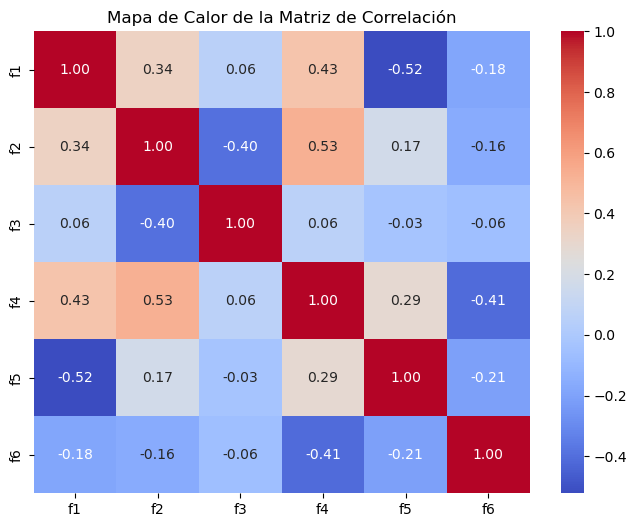

In [29]:
# Calculamos la matriz de correlación
correlation_matrix = final_DF[final_DF.columns[:-1]].corr()

print("Matriz de correlación:")
print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

# Usamos la matriz de correlación que calculamos antes
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de la Matriz de Correlación')
plt.show()